In [1]:
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tifffile
from osgeo import gdal
from pyidw import idw
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
from rasterio.features import geometry_mask
from rasterio.transform import from_origin

In [2]:
df=pd.read_csv("sample_230307.csv") # csv형식의 데이터파일 불러오기.
df.columns
df.head()

Index(['지점정보', '경도', '위도', '평균기온', '최저기온', '최고기온'], dtype='object')

,지점정보,경도,위도,평균기온,최저기온,최고기온
0,속초(90),128.56473,38.25085,14.4,11.2,18.0
1,북춘천(93),127.75443,37.94738,7.8,-2.2,18.2
2,철원(95),127.30420,38.14787,7.8,-2.0,17.1
3,동두천(98),127.06070,37.90188,9.8,2.5,19.7
4,파주(99),126.76648,37.88589,7.8,0.4,16.6


In [3]:
# geodataframe 형식으로 만든 후, csv파일을 shp파일로 변환. 

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.경도, df.위도))
gdf.drop(['지점정보', '경도', '위도'],axis=1,inplace=True)
gdf
gdf.columns=['mean_temp','low_temp','high_temp','geometry']
gdf.to_file('temperatures.shp')

,평균기온,최저기온,최고기온,geometry
0,14.4,11.2,18.0,POINT (128.56473 38.25085)
1,7.8,-2.2,18.2,POINT (127.75443 37.94738)
2,7.8,-2.0,17.1,POINT (127.30420 38.14787)
3,9.8,2.5,19.7,POINT (127.06070 37.90188)
4,7.8,0.4,16.6,POINT (126.76648 37.88589)
...,...,...,...,...
92,10.1,0.8,21.2,POINT (128.74412 35.49147)
93,9.5,-1.1,22.0,POINT (127.87910 35.41300)
94,12.6,5.8,17.5,POINT (128.60459 34.88818)
95,12.2,5.6,19.2,POINT (127.92641 34.81662)


In [4]:
data_file = gpd.read_file("temperatures.shp") # shp파일 읽기
data_file
boundary_file = gpd.read_file("boundary.shp") # shp파일 읽기(데이터가 한줄로 있어야 함.)
boundary_file
#tif_file = rasterio.open("altitude2_idw.tif") # tif파일 읽기
#tif_file

,mean_temp,low_temp,high_temp,geometry
0,14.4,11.2,18.0,POINT (128.56473 38.25085)
1,7.8,-2.2,18.2,POINT (127.75443 37.94738)
2,7.8,-2.0,17.1,POINT (127.30420 38.14787)
3,9.8,2.5,19.7,POINT (127.06070 37.90188)
4,7.8,0.4,16.6,POINT (126.76648 37.88589)
...,...,...,...,...
92,10.1,0.8,21.2,POINT (128.74412 35.49147)
93,9.5,-1.1,22.0,POINT (127.87910 35.41300)
94,12.6,5.8,17.5,POINT (128.60459 34.88818)
95,12.2,5.6,19.2,POINT (127.92641 34.81662)


,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,GID,geometry
0,42000,강원도,NaN,42830,184,"MULTIPOLYGON (((128.60636 38.15970, 128.60637 ..."


<AxesSubplot:>

<AxesSubplot:>

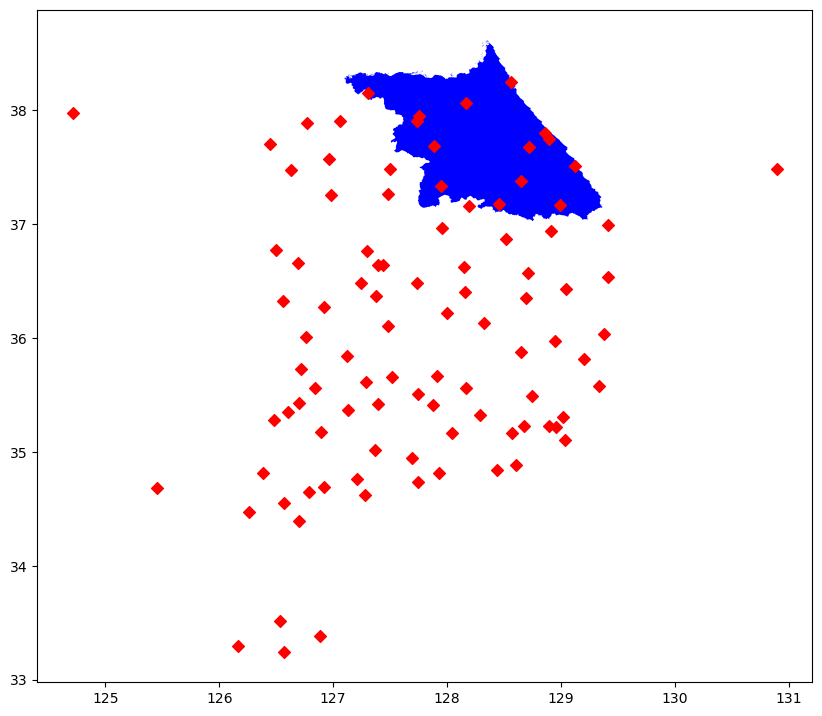

In [6]:
fig, ax = plt.subplots(figsize=(10,9))
boundary_file.plot(ax=ax, marker='D', color='b') # shp파일 띄우기 (경계)
data_file.plot(ax=ax, marker='D', color='r') # shp파일 띄우기 (데이터)
#rasterio.plot.show(tif_file) # tif 파일 띄우기
plt.show()

0

0

0

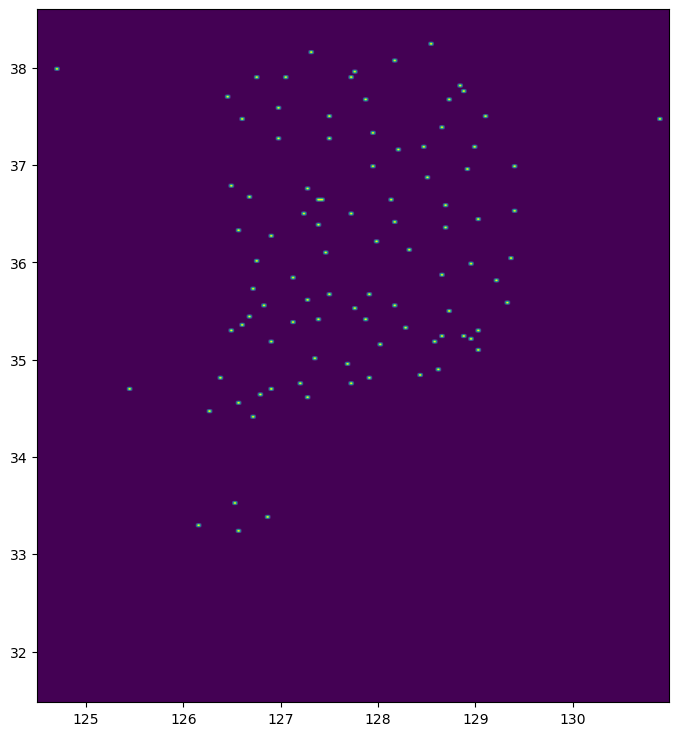

<AxesSubplot:>

In [7]:
#-- shp파일을 tif파일로 바꾸기
#---------------------------
#---------------------------

shp_path  = "temperatures.shp" # 현재 shp파일 이름 
tif_path  = "temperatures.tif" # 만들고자 하는 tif파일 이름

driver = gdal.GetDriverByName('GTiff')

# shp 파일을 읽어오기
shp_datasource = gdal.OpenEx(shp_path, gdal.OF_VECTOR)

# tif 파일 생성
tif_datasource = driver.Create(tif_path, 174, 249, 1, gdal.GDT_Float32)

# 투영 좌표계 설정
tif_datasource.SetProjection(shp_datasource.GetProjection())

# 변환할 래스터 데이터가 위치할 래스터 영역 설정
xmin, ymin, xmax, ymax = shp_datasource.GetLayer().GetExtent()

# 범위 설정이 이상함. 
xmin = 124.5 
ymin = 10.0 
xmax = 161.8 
ymax = 38.6

tif_datasource.SetGeoTransform((xmin, (xmax-xmin)/1000, 0, ymax, 0, -(ymax-ymin)/1000))

# 래스터화
gdal.RasterizeLayer(tif_datasource, [1], shp_datasource.GetLayer())

# 파일 닫기
shp_datasource = None
tif_datasource = None

# 생성된 파일 시각화
tif_file = rasterio.open("temperatures.tif") # tif파일 읽기
fig, ax = plt.subplots(figsize=(10,9))
rasterio.plot.show(tif_file) # tif 파일 띄우기
plt.show()

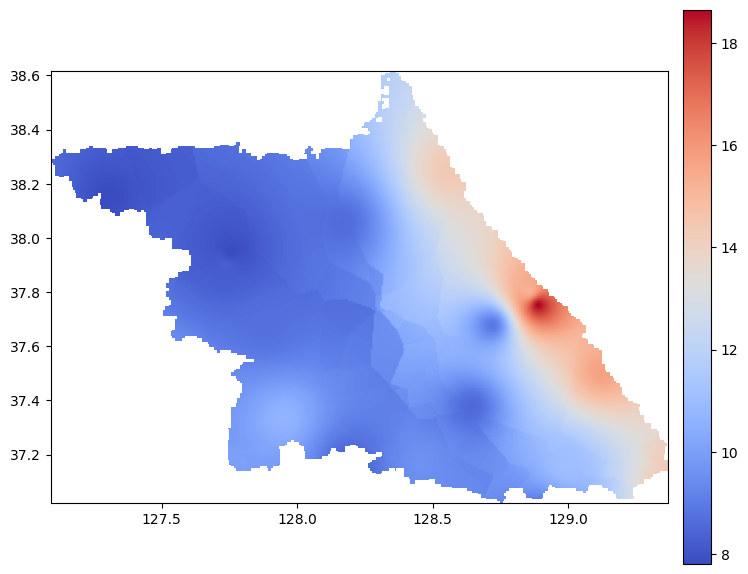

In [13]:
idw.idw_interpolation(
    input_point_shapefile="temperatures.shp", # 보간하고자 하는 shp 파일 
    extent_shapefile="boundary.shp", # 경계 shp 파일 
    #bd = gpd.read_file("adad.shp")
    column_name="mean_temp", # 보간하고자 하는 column 이름. 
    power=2, # 거리 가중치 계수 
    search_radious=8, # 검색하고자 하는 범위 
    output_resolution=400, # 결과물 해상도 
)

In [14]:
# 보간된 파일을 이쁘게 시각화 하는 함수 
def show_map(input_raster='', colormap='Blues', image_size=1.5, return_figure=False):
    with rasterio.open(input_raster) as image_data:
        my_matrix = image_data.read(1)
        my_matrix = np.ma.masked_where(my_matrix == 32767, my_matrix)
        fig, ax = plt.subplots()
        image_hidden = ax.imshow(my_matrix, cmap=colormap)
        plt.close()

        fig, ax = plt.subplots()
        fig.set_facecolor("w")
        width = fig.get_size_inches()[0] * image_size
        height = fig.get_size_inches()[1] * image_size
        fig.set_size_inches(w=width, h=height)
        image = show(image_data, cmap=colormap, ax=ax)
        #cbar = fig.colorbar(image_hidden, ax=ax, pad=0.02)

        cbar = fig.colorbar(image_hidden, ax=ax, pad=0.02,spacing='uniform',extend='both')
        if return_figure == False:
            plt.show()
        else:
            return fig, ax, cbar

Text(0.5, 1.0, 'Temperature map')

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

Text(0, 0.5, 'Temperature range')

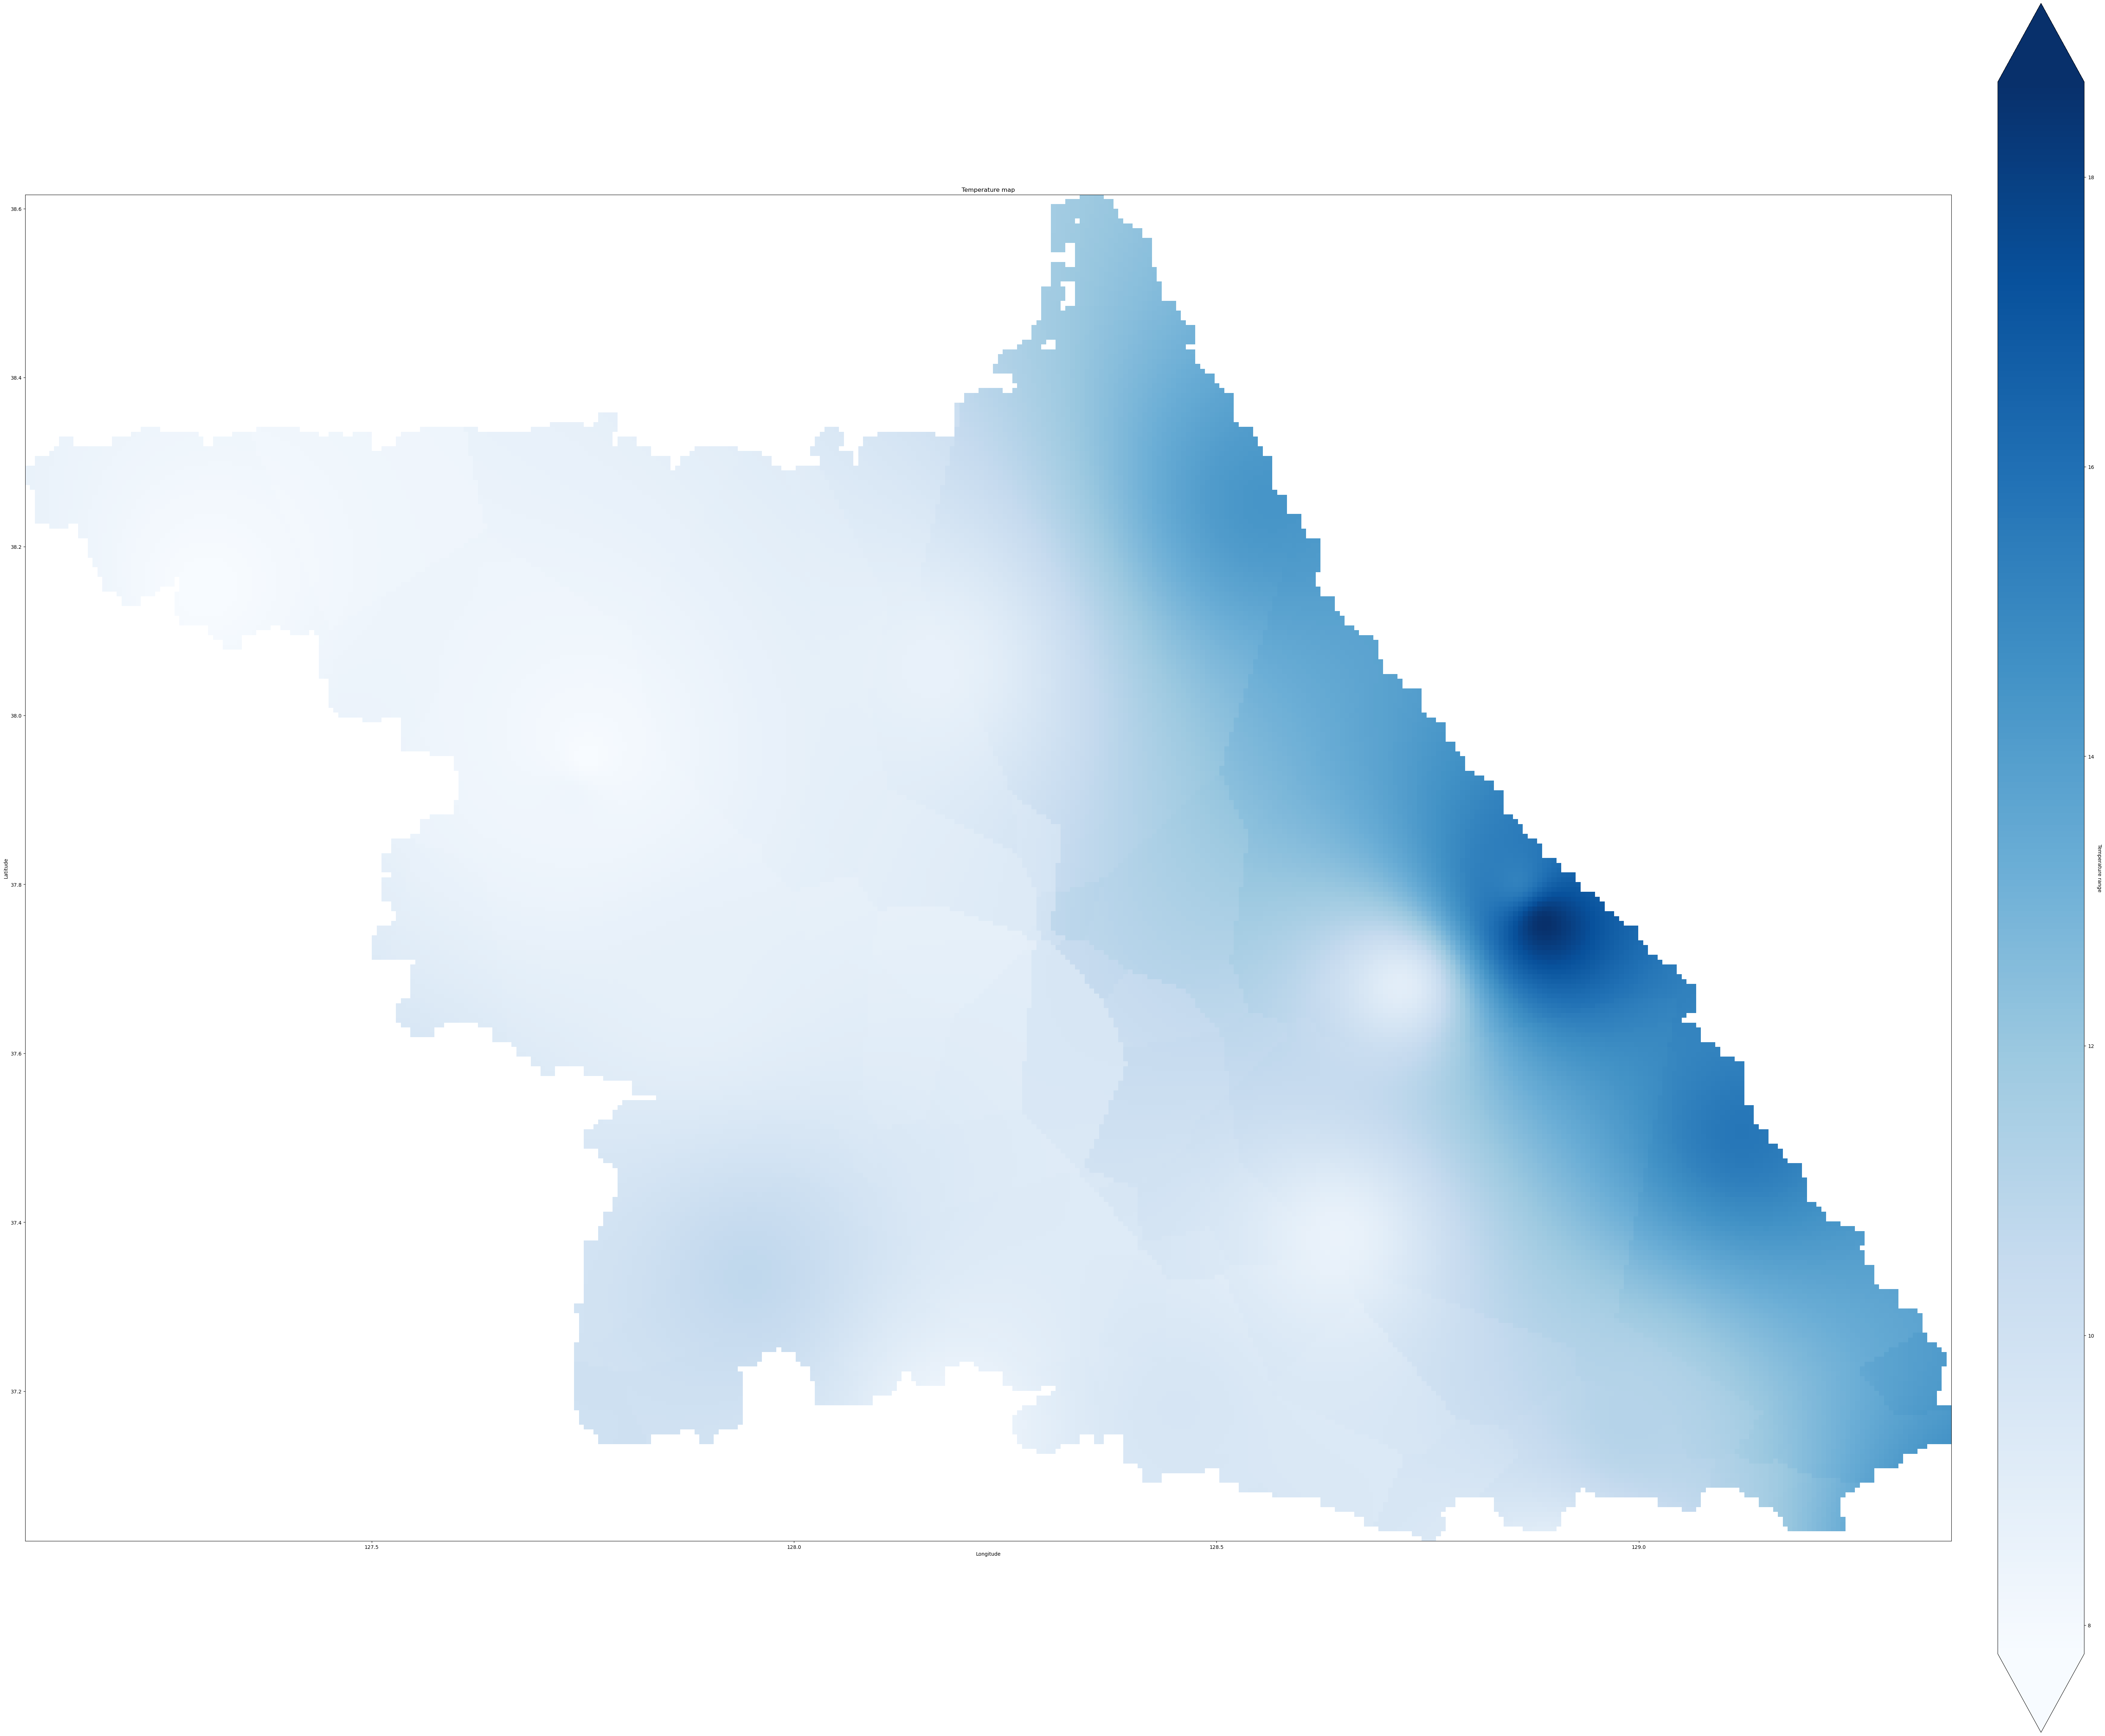

In [15]:
fig, ax, cbar = show_map(
    input_raster="temperatures_idw.tif",
    colormap="Blues",
    image_size=13,
    return_figure=True)

ax.set_title("Temperature map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar.set_label("temperature")
cbar.ax.set_ylabel('Temperature range', rotation=270, labelpad=15)
plt.show()

In [11]:
# tif파일을 csv로 만드는 함수 

data = tifffile.imread('temperatures_idw.tif')

print('Array shape:', data.shape)
print('Data type:', data.dtype)

data=pd.DataFrame(data)
data
data.to_csv('tif_data.csv')

Array shape: (174, 249)
Data type: float64


,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
1,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
2,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
3,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
4,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
170,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
171,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0
172,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,...,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0,32767.0


In [12]:
# 보간하지 않은 파일을 경계로 잘라내는 함수 수정 중 

with rasterio.open('adad_test_test2.tif') as baseRasterFile:
        inputPoints = gpd.read_file('gw_altitude2.shp')
        # obser_df stands for observation_dataframe, lat, lon, data_value for each station will be stored here.
        obser_df = pd.DataFrame()
        obser_df['station_name'] = inputPoints.iloc[:, 0]

        # create two list of indexes of station longitude, latitude in elevation raster file.
        lons, lats = baseRasterFile.index(
            [lon for lon in inputPoints.geometry.x],
            [lat for lat in inputPoints.geometry.y])
        obser_df['lon_index'] = lons
        obser_df['lat_index'] = lats
        obser_df['data_value'] = inputPoints['z']

        idw_array = baseRasterFile.read(1)
        for x in range(baseRasterFile.height):
            for y in range(baseRasterFile.width):
                if baseRasterFile.read(1)[x][y] == 32767:
                    continue
                else:
                    print(x,y)
                    try:
                        datas=obser_df[(obser_df['lon_index']==x) & (obser_df['lat_index']==y) ]['data_value'].values[0]
                        datas
                        idw_array[x][y] = datas
                    except:
                        idw_array[x][y] = -99999

        output_filename = 'altitude2_idw.tif'
        with rasterio.open(output_filename, 'w', **baseRasterFile.meta) as std_idw:
            std_idw.write(idw_array, 1)

        #show_map(output_filename)

RasterioIOError: adad_test_test2.tif: No such file or directory